Lab 4 Recurrent Neural Network
===

## Contents
A. 20 Newsgroups
    1. Text Data Preprocessing for 20 news groups
    2. Linear Classifiers (MultinomialNB with TF-IDF feature selection, Logistic Regression)
    3. Pure CNN based text classifier with pretrained word embedding
    4. LSTM based RNN text classifier with pretrained word embedding
    5. Stacked and Bidirectional LSTM RNN examples
    6. LSTM based RNN text classifier with pretrained word embedding trained via Truncated BPTT (TBPTT)
B. Consumer Finance Complaints
    1. Text Data Proprocessing for complaint data

## Data
You'll need to download and uncompress the following:

1. 20 newsgroups 
    1. [20 newsgroups](http://qwone.com/~jason/20Newsgroups/) **(16.5Mb)**
    2. Note: you should put the 20_newsgroups directory in the same directory as this notebook

2. US Consumer Finance Complaints 
    1. [Kaggle Competition](https://www.kaggle.com/cfpb/us-consumer-finance-complaints/data) **(90.4Mb)**
    2. Note: you should put the consumer_complaints.csv file in the same directory as this notebook
    
3. GloVe word embeddings -- better than word2vec 
    1. [GloVE 6B](https://nlp.stanford.edu/projects/glove/) **(822Mb)**
    2. Note: you should download glove.6B.zip, unzip it, and put glove.6B in the same directory as this notebook
    
## Assignment
This assignment is the easiest of the four assignments.  This is intentional -- you should gain quick experience with the RNN (and how slow they are to train) in order to guide your final project choice and allow you to start into your final project ASAP.

This assignment is simply about using RNNs to train classifiers.  Encoder-decoder RNN models will be explored in a different lab (for the auto-correct example), but they are far slower to train than the RNNs used in this assignment (which are standard RNNs, not the encoder-decoder models).

Your basic choices in RNNs are the following:
    1. For text: word embedding (typically word2vec or GloVe, but you can also train them yourself!)
    2. Number of latent layers (stacked layers)
    3. Dimensions of latent layers
    4. Whether the latent layers are bidirectional or unidirectional
    5. Type of latent layer transition (linear, linear with sigmoid, LSTM, GRU, ...)
    6. Choice of optimizer, batch size, learning rates and other parameters for some optimizers
    7. Many more complex choices for latent layer that typically require modifying the Tensorflow model directly (not covered here)
    
Your assignment tasks (you can commit different notebooks for each question, just clearly label them Q1 and Q2):

**Q1.** Increase the epochs of the 20 newsgroups examples to at least 20 epochs and run this notebook overnight to get results... you can save the results in a different notebook and commit to your assignment repository (we simply want to verify that you ran this notebook for at least 20 epochs).  Directly below this question, answer (a) which architecture worked best and why you hypothesize that is the case, and (b) do the same for the worst performing architecture.
    
**Q2.** Run the above architectures for the financial data (note that this data is typically much shorter in length).  Try out at least two different architectures (not just optimizer settings, etc.) to see if you can improve the results.  Directly below this question, (a) describe the two architectures you proposed and why you think they might improve results, (b) answer which architecture worked best (reference a graph) and why you hypothesize this is the case, and (c) do the same for the worst performing architecture.

**Submission.** You can commit different notebooks for each question, just label them and include Q1 or Q2 in the filename.

# Reference for some of the following code for 20 newsgroups
[Using pre-trained word embeddings in a Keras model](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html)

**NOTE**: The claim on the above blog about 95% accuracy on 20 newsgroups is incorrect -- the blog included the email header which contains the target label in the features!  **The true accuracy of the model with the header removed is 71%.**

In [1]:
class_names = ['alt.atheism',
                 'comp.graphics',
                 'comp.os.ms-windows.misc',
                 'comp.sys.ibm.pc.hardware',
                 'comp.sys.mac.hardware',
                 'comp.windows.x',
                 'misc.forsale',
                 'rec.autos',
                 'rec.motorcycles',
                 'rec.sport.baseball',
                 'rec.sport.hockey',
                 'sci.crypt',
                 'sci.electronics',
                 'sci.med',
                 'sci.space',
                 'soc.religion.christian',
                 'talk.politics.guns',
                 'talk.politics.mideast',
                 'talk.politics.misc',
                 'talk.religion.misc']

In [2]:
def print_confusion_matrix(confusion_matrix, class_names, 
                           figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Basic Packages

In [4]:
!pip install tensorflow

    100% |################################| 45.9MB 36kB/s s eta 0:00:01
    100% |################################| 3.1MB 552kB/s eta 0:00:011
    100% |################################| 7.5MB 227kB/s  eta 0:00:01
    100% |################################| 81kB 14.2MB/s ta 0:00:01
    100% |################################| 890kB 1.9MB/s eta 0:00:011
    100% |################################| 81kB 11.5MB/s ta 0:00:01
  Running setup.py bdist_wheel for gast ... done
  Stored in directory: /home/ubuntu/.cache/pip/wheels/8e/fa/d6/77dd17d18ea23fd7b860e02623d27c1be451521af40dd4a13e
  Running setup.py bdist_wheel for termcolor ... done
  Stored in directory: /home/ubuntu/.cache/pip/wheels/de/f7/bf/1bcac7bf30549e6a4957382e2ecab04c88e513117207067b03
  Running setup.py bdist_wheel for absl-py ... done
  Stored in directory: /home/ubuntu/.cache/pip/wheels/d6/d5/fc/8405dfaa90e82a8665116b5058e14891c37b4a0a707e03b634
  Running setup.py bdist_wheel for html5lib ... done
  Stored in directory: /hom

In [3]:
from __future__ import print_function
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import numpy as np
import tensorflow as tf
import pandas as pd
import pickle
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.utils import to_categorical

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Constants

In [4]:
BASE_DIR = ''
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6b')
TEXT_DATA_DIR = os.path.join(BASE_DIR, '20_newsgroups')
MAX_SEQUENCE_LENGTH = 2500
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.4

## Text Data Processing

In [5]:
def get_data(data_path):
    texts = []  # list of text samples
    labels_index = {}  # dictionary mapping label name to numeric id
    labels = []  # list of label ids
    for name in sorted(os.listdir(data_path)):
        path = os.path.join(data_path, name)
        if os.path.isdir(path):
            label_id = len(labels_index)
            labels_index[name] = label_id
            for fname in sorted(os.listdir(path)):
                if fname.isdigit():
                    fpath = os.path.join(path, fname)
                    args = {} if sys.version_info < (3,) else {'encoding': 'latin-1'}
                    with open(fpath, **args) as f:
                        t = f.read()
                        i = t.find('\n\n')  # Skip header which contains label!!!
                        if 0 < i:
                            t = t[i:]
                        texts.append(t)
                    labels.append(label_id)
    return texts, labels_index, labels

In [6]:
texts, labels_index, labels = get_data(TEXT_DATA_DIR)

In [7]:
indices = np.arange(len(texts))
np.random.shuffle(indices)
num_validation_samples = int(VALIDATION_SPLIT * len(texts))

In [8]:
def data_preprocessing(texts, labels, indices, num_validation_samples, classifier="NeuralNetwork"):
    
    word_index = None
    
    if classifier == "NeuralNetwork":
        tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
        tokenizer.fit_on_texts(texts)
        sequences = tokenizer.texts_to_sequences(texts)
        
        plt.figure()
        plt.hist([len(x) for x in sequences])
        plt.xlabel('Length of Document')
        plt.ylabel('Number of Documents')
        plt.title('Statistic of Data')
        plt.grid(True)
        plt.show()
        
        word_index = tokenizer.word_index
        
        with open('tokenizer.pickle', 'wb') as handle:
            pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
        
    else:
        vectorizer = TfidfVectorizer()
        data = vectorizer.fit_transform(texts)
    
    labels = to_categorical(np.asarray(labels))  
    data = data[indices]
    labels = labels[indices]

    x_train = data[:-num_validation_samples]
    y_train = labels[:-num_validation_samples]
    x_val = data[-num_validation_samples:]
    y_val = labels[-num_validation_samples:]
    
    return x_train, y_train, x_val, y_val, word_index        

In [9]:
experiment_result = dict()

## SKLEARN

In [31]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

In [32]:
x_train, y_train, x_val, y_val, _ = data_preprocessing(texts, 
                                                       labels, 
                                                       indices, 
                                                       num_validation_samples, 
                                                       classifier="SKLEARN")

In [33]:
clf =  MultinomialNB(alpha=0.1)
clf.fit(x_train, np.argmax(y_train, axis=1))
pred = clf.predict(x_val)
experiment_result['NB'] = metrics.accuracy_score(np.argmax(y_val, axis=1), pred)

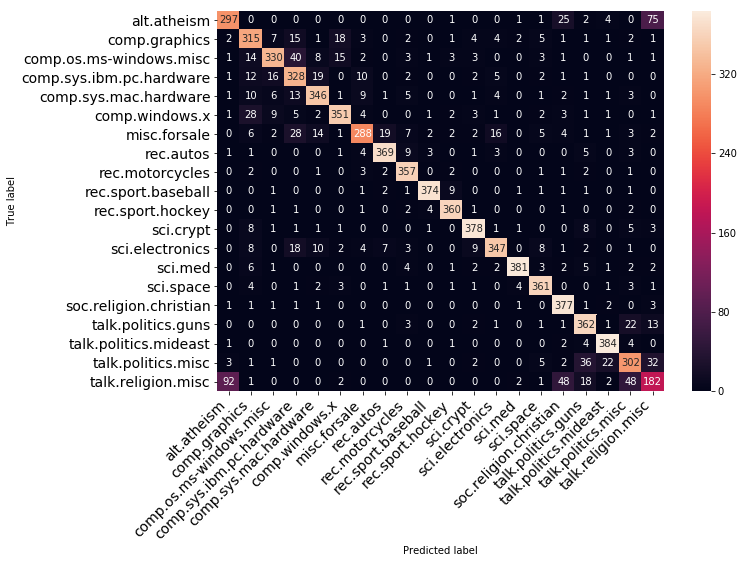

In [34]:
print_confusion_matrix(metrics.confusion_matrix(np.argmax(y_val, axis=1), pred), 
                       class_names)

In [35]:
clf =  LogisticRegression()
clf.fit(x_train, np.argmax(y_train, axis=1))
pred = clf.predict(x_val)
experiment_result['LR'] = metrics.accuracy_score(np.argmax(y_val, axis=1), pred)

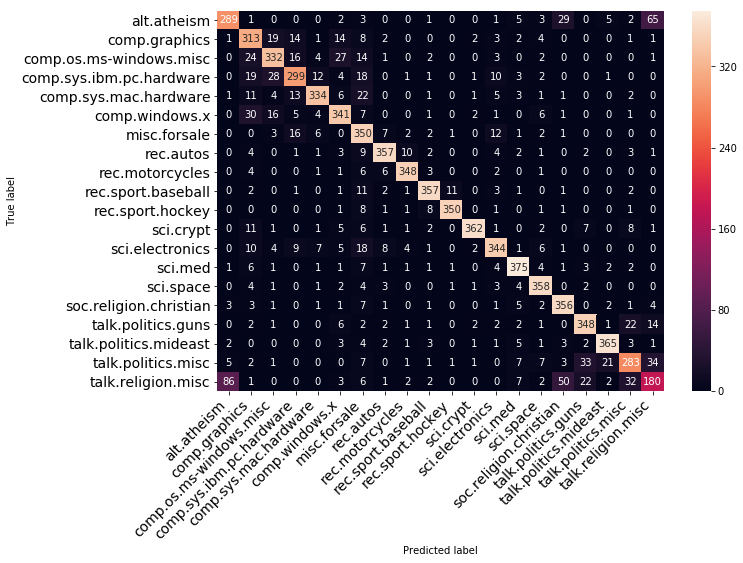

In [36]:
print_confusion_matrix(metrics.confusion_matrix(np.argmax(y_val, axis=1), pred), 
                       class_names)

## Tensorflow

In [12]:
def show_curve(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [13]:
from tensorflow.python.keras.layers import Dense, Input, GlobalMaxPooling1D, Flatten
from tensorflow.python.keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM, GRU, Concatenate, Dropout
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import backend as K

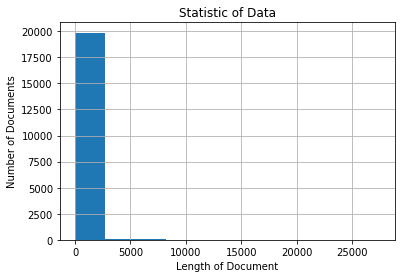

In [14]:
x_train, y_train, x_val, y_val, word_index = data_preprocessing(texts, 
                                                                labels, 
                                                                indices, 
                                                                num_validation_samples, 
                                                                classifier="NeuralNetwork")

In [15]:
def get_embedding_matrix(word_index):
    
    embeddings_index = {}
    with open(os.path.join(GLOVE_DIR, 'glove.6B.{0}d.txt'.format(EMBEDDING_DIM)), encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    
    num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
    embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
    for word, i in word_index.items():
        if i >= MAX_NUM_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix, num_words

In [16]:
embedding_matrix, num_words = get_embedding_matrix(word_index)

### CNN

In [24]:
tf.reset_default_graph()
try:
    del model
except:
    pass
K.clear_session()

graph = tf.get_default_graph()
with graph.as_default():
    #Pretrained
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False #True when retrain
                               )
    #Train embedding
#     embedding_layer = Embedding(len(word_index) + 1,
#                                 EMBEDDING_DIM,
#                                 input_length=MAX_SEQUENCE_LENGTH)

    print('Training model.')

    # train a 1D convnet with global maxpooling
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = Conv1D(128, 5, activation='relu')(embedded_sequences)
    x = MaxPooling1D(5)(x)
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(5)(x)
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(5)(x)
    x = Conv1D(128, 5, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(128, activation='relu')(x)
    preds = Dense(len(labels_index), activation='softmax')(x)

    model = Model(sequence_input, preds)
    model._make_predict_function()
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])

    history = model.fit(x_train, y_train,
                        batch_size=128,
                        epochs=20, # Change this to at least 20 for final run
                        validation_data=(x_val, y_val))

Training model.
Train on 11999 samples, validate on 7998 samples
Epoch 1/20
11999/11999 [==============================]11999/11999 [==============================] - 123s 10ms/step - loss: 2.7276 - acc: 0.1258 - val_loss: 2.3107 - val_acc: 0.1993

Epoch 2/20
11999/11999 [==============================]11999/11999 [==============================] - 123s 10ms/step - loss: 2.0862 - acc: 0.2768 - val_loss: 1.8552 - val_acc: 0.3460

Epoch 3/20
11999/11999 [==============================]11999/11999 [==============================] - 122s 10ms/step - loss: 1.7203 - acc: 0.3841 - val_loss: 1.6902 - val_acc: 0.3987

Epoch 4/20
11999/11999 [==============================]11999/11999 [==============================] - 122s 10ms/step - loss: 1.4152 - acc: 0.4954 - val_loss: 1.5342 - val_acc: 0.4761

Epoch 5/20
11999/11999 [==============================]11999/11999 [==============================] - 122s 10ms/step - loss: 1.2094 - acc: 0.5766 - val_loss: 1.1527 - val_acc: 0.6065

Epoch 6/20
1199

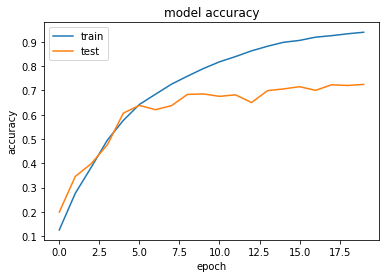

In [25]:
show_curve(history)

In [26]:
pred = model.predict(x_val)
experiment_result['CNN'] = metrics.accuracy_score(np.argmax(y_val, axis=1), np.argmax(pred, axis=1))

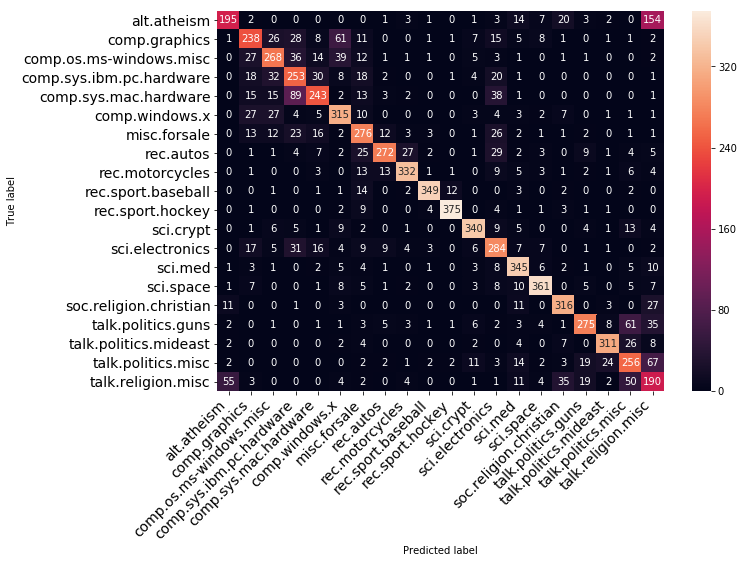

In [27]:
print_confusion_matrix(metrics.confusion_matrix(np.argmax(y_val, axis=1), np.argmax(pred, axis=1)), 
                       class_names)

### LSTM
1. need to run more 20 epochs to close to converge
2. Warning: It can take >3 hours!

In [28]:
tf.reset_default_graph()
try:
    del model
except:
    pass
K.clear_session()

with graph.as_default():
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False #True when retrain
                               )
    #Train embedding
#     embedding_layer = Embedding(len(word_index) + 1,
#                                 EMBEDDING_DIM,
#                                 input_length=MAX_SEQUENCE_LENGTH)

    print('Training model.')

    # train a single layer LSTM recurrent neural network
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    # Replace LSTM with GRU if you want
    x,_,_ = LSTM(EMBEDDING_DIM, return_state=True)(embedded_sequences)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    preds = Dense(len(labels_index), activation='softmax')(x)

    model = Model(sequence_input, preds)
    model._make_predict_function()
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])

    history=model.fit(x_train, y_train,
                      batch_size=128,
                      epochs=20, # Change this to at least 20 for final run
                      validation_data=(x_val, y_val))

Training model.
Train on 11999 samples, validate on 7998 samples
Epoch 1/20
11999/11999 [==============================]11999/11999 [==============================] - 288s 24ms/step - loss: 2.7768 - acc: 0.1297 - val_loss: 2.4346 - val_acc: 0.1807

Epoch 2/20
11999/11999 [==============================]11999/11999 [==============================] - 287s 24ms/step - loss: 2.3605 - acc: 0.2159 - val_loss: 2.1626 - val_acc: 0.2482

Epoch 3/20
11999/11999 [==============================]11999/11999 [==============================] - 288s 24ms/step - loss: 2.0910 - acc: 0.2924 - val_loss: 1.9653 - val_acc: 0.3272

Epoch 4/20
11999/11999 [==============================]11999/11999 [==============================] - 287s 24ms/step - loss: 1.8346 - acc: 0.3663 - val_loss: 1.7027 - val_acc: 0.4152

Epoch 5/20
11999/11999 [==============================]11999/11999 [==============================] - 286s 24ms/step - loss: 1.5698 - acc: 0.4572 - val_loss: 1.4557 - val_acc: 0.4949

Epoch 6/20
1199

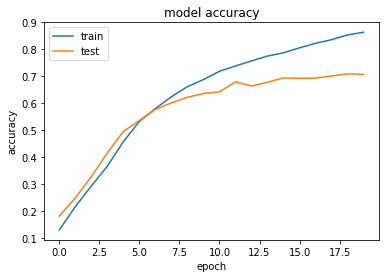

In [29]:
show_curve(history)

In [31]:
    '''
    what is this for?
    
    history=model.fit(x_train, y_train,
                      batch_size=128,
                      epochs=10,
                      validation_data=(x_val, y_val))
    '''

'\nwhat is this for?\n\nhistory=model.fit(x_train, y_train,\n                  batch_size=128,\n                  epochs=10,\n                  validation_data=(x_val, y_val))\n'

In [32]:
with graph.as_default():
    pred = model.predict(x_val)
    experiment_result['RNN'] = metrics.accuracy_score(np.argmax(y_val, axis=1), np.argmax(pred, axis=1))

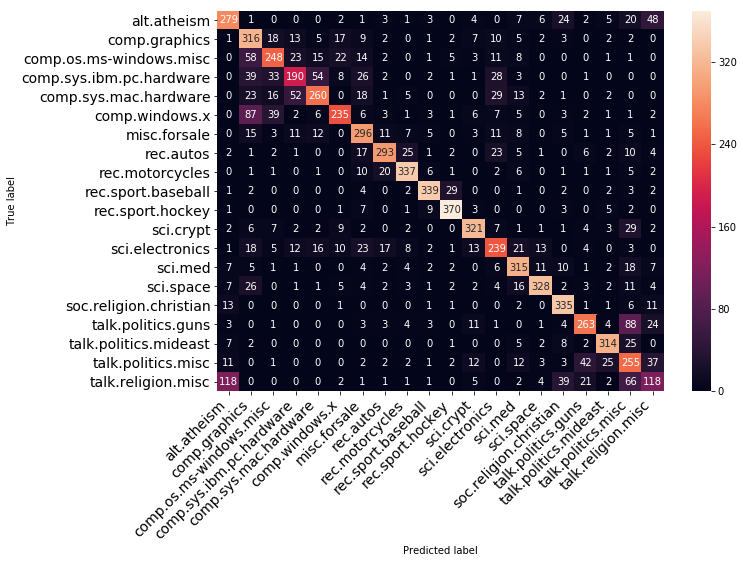

In [33]:
print_confusion_matrix(metrics.confusion_matrix(np.argmax(y_val, axis=1), np.argmax(pred, axis=1)), 
                       class_names)

In [29]:
def show_bar(experiment_result):
    df = pd.DataFrame(columns=['Algorithm','Score'])
    for key, value in experiment_result.items():
        df = df.append({'Algorithm': key, 'Score':value}, ignore_index=True)
    sns.barplot(x=df['Algorithm'], y=df['Score'], ci=None)
    plt.show()

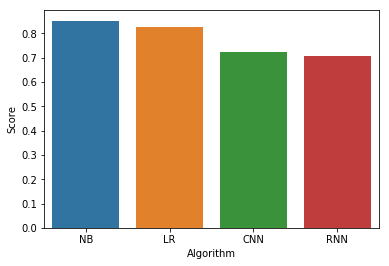

In [35]:
df = show_bar(experiment_result)

### Bidirectional LSTM + LSTM

In [15]:
graph = tf.get_default_graph()
tf.reset_default_graph()
try:
    del model
except:
    pass
K.clear_session()
with graph.as_default():
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False #True when retrain
                               )
    #Train embedding
#     embedding_layer = Embedding(len(word_index) + 1,
#                                 EMBEDDING_DIM,
#                                 input_length=MAX_SEQUENCE_LENGTH)

    print('Training model.')

    # train 2 Layer LSTM model with first LSTM to bidirectional
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x1 = LSTM(EMBEDDING_DIM, return_sequences=True)(embedded_sequences)
    x2 = LSTM(EMBEDDING_DIM, return_sequences=True, go_backwards=True)(embedded_sequences)
    x = Concatenate()([x1, x2])
    x,_,_ = LSTM(EMBEDDING_DIM, return_state=True)(x) # Note: this layer takes previous LSTM layer as input!
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    preds = Dense(len(labels_index), activation='softmax')(x)

    model = Model(sequence_input, preds)
    model._make_predict_function()
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])

    history = model.fit(x_train, y_train,
                         batch_size=128,
                         epochs=20, # Change this to at least 20 for final run
                         validation_data=(x_val, y_val))

Training model.
Train on 11999 samples, validate on 7998 samples
Epoch 1/20
11999/11999 [==============================]11999/11999 [==============================] - 924s 77ms/step - loss: 2.7698 - acc: 0.1185 - val_loss: 2.6176 - val_acc: 0.1452

Epoch 2/20
11999/11999 [==============================]11999/11999 [==============================] - 925s 77ms/step - loss: 2.4180 - acc: 0.1891 - val_loss: 2.1478 - val_acc: 0.2424

Epoch 3/20
11999/11999 [==============================]11999/11999 [==============================] - 924s 77ms/step - loss: 2.2480 - acc: 0.2367 - val_loss: 2.1067 - val_acc: 0.2532

Epoch 4/20
11999/11999 [==============================]11999/11999 [==============================] - 923s 77ms/step - loss: 2.0628 - acc: 0.2865 - val_loss: 2.2811 - val_acc: 0.2404

Epoch 5/20
11999/11999 [==============================]11999/11999 [==============================] - 925s 77ms/step - loss: 1.8900 - acc: 0.3385 - val_loss: 1.7323 - val_acc: 0.3850

Epoch 6/20
1199

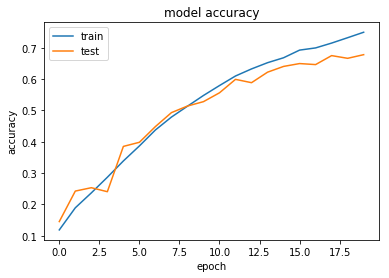

In [16]:
show_curve(history)

In [ ]:
with graph.as_default():
    pred = model.predict(x_val)
    experiment_result['BRNN'] = metrics.accuracy_score(np.argmax(y_val, axis=1), np.argmax(pred, axis=1))

In [ ]:
print_confusion_matrix(metrics.confusion_matrix(np.argmax(y_val, axis=1), np.argmax(pred, axis=1)), 
                       class_names)

## Train Simple RNN with Truncated Backprop Through Time (TBPTT)

In [17]:
MAX_SEQUENCE_LENGTH = 100 # Chunk size for TBPTT

In [18]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [19]:
def data_preprocessing_v2(texts, labels, word_index, indices, num_validation_samples, classifier="NeuralNetwork"):
    
    word_index = None
    
    new_sequences = []
    new_labels = []
    
    texts = [texts[i] for i in indices]
    labels = [labels[i] for i in indices]
    texts = texts[:-num_validation_samples]
    labels = labels[:-num_validation_samples]
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)
    
    print(len(tokenizer.word_index))
    sequences = tokenizer.texts_to_sequences(texts)

    for index, sequence in enumerate(sequences):
        split_sequence = list(chunks(sequence, 100)) # Break sequences into 100-length chunks for training!
        label = labels[index]
        new_sequences += split_sequence
        new_labels += [label]*len(split_sequence)

    print(len(new_sequences), len(new_labels))

    sequences = new_sequences
    labels = new_labels

    plt.figure()
    plt.hist([len(x) for x in sequences])
    plt.xlabel('Length of Document')
    plt.ylabel('Number of Documents')
    plt.title('Statistic of Data')
    plt.grid(True)
    plt.show()

    word_index = tokenizer.word_index
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    labels = to_categorical(np.asarray(labels))  
    
    return data, labels    

174074
37530 37530


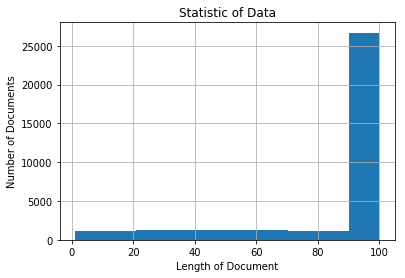

In [20]:
x_train, y_train = data_preprocessing_v2(texts, 
                                         labels,
                                         word_index,
                                         indices,
                                         num_validation_samples)

In [21]:
indices

array([17608, 18535,  8397, ...,  2824, 10790,  4023])

In [22]:
x_train.shape

(37530, 100)

In [23]:
graph = tf.get_default_graph()

tf.reset_default_graph()
try:
    del model
except:
    pass
K.clear_session()

with graph.as_default():
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False #True when retrain
                               )
    #Train embedding
#     embedding_layer = Embedding(len(word_index) + 1,
#                                 EMBEDDING_DIM,
#                                 input_length=MAX_SEQUENCE_LENGTH)

    print('Training model.')

    # train a single layer LSTM recurrent neural network
    sequence_input = Input(shape=(None,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    # Replace LSTM with GRU if you want
    x,_,_ = LSTM(EMBEDDING_DIM, return_state=True)(embedded_sequences)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    preds = Dense(len(labels_index), activation='softmax')(x)

    model = Model(sequence_input, preds)
    model._make_predict_function()
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])

    history=model.fit(x_train, y_train,
                      batch_size=128,
                      epochs=20, # Change this to at least 20 for final run
                      validation_data=(x_val, y_val))

Training model.
Train on 37530 samples, validate on 7998 samples
Epoch 1/20
37530/37530 [==============================]37530/37530 [==============================] - 80s 2ms/step - loss: 2.0958 - acc: 0.3151 - val_loss: 2.2511 - val_acc: 0.2941

Epoch 2/20
37530/37530 [==============================]37530/37530 [==============================] - 80s 2ms/step - loss: 1.4704 - acc: 0.5090 - val_loss: 1.5529 - val_acc: 0.4762

Epoch 3/20
37530/37530 [==============================]37530/37530 [==============================] - 80s 2ms/step - loss: 1.2217 - acc: 0.6000 - val_loss: 1.2020 - val_acc: 0.6009

Epoch 4/20
37530/37530 [==============================]37530/37530 [==============================] - 80s 2ms/step - loss: 1.0877 - acc: 0.6434 - val_loss: 1.1239 - val_acc: 0.6400

Epoch 5/20
37530/37530 [==============================]37530/37530 [==============================] - 80s 2ms/step - loss: 0.9933 - acc: 0.6744 - val_loss: 1.1114 - val_acc: 0.6297

Epoch 6/20
37530/37530 [=

In [24]:
MAX_SEQUENCE_LENGTH = 2500

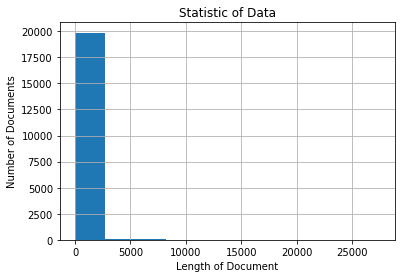

In [25]:
_, _, x_val, y_val, word_index = data_preprocessing(texts, 
                                                                labels,  
                                                                indices,
                                                                num_validation_samples, 
                                                                classifier="NeuralNetwork")

In [26]:
with graph.as_default():
    pred = model.predict(x_val)
    experiment_result['RNN-Short'] = metrics.accuracy_score(np.argmax(y_val, axis=1), np.argmax(pred, axis=1))

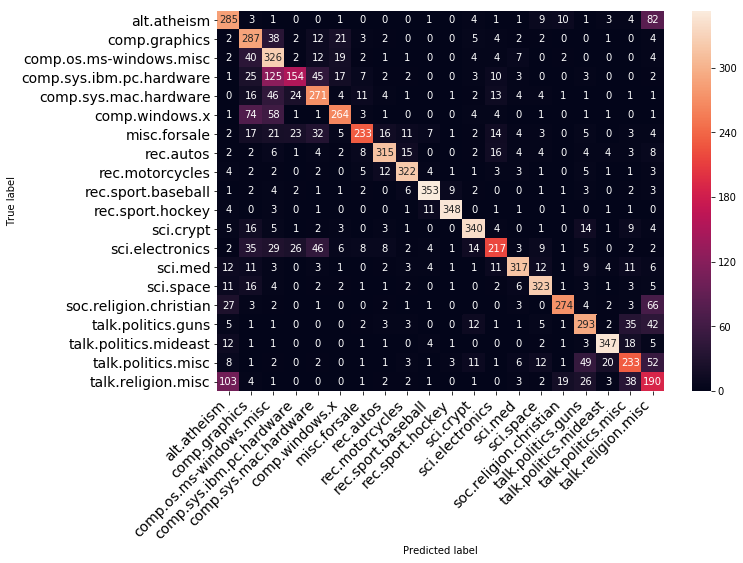

In [27]:
print_confusion_matrix(metrics.confusion_matrix(np.argmax(y_val, axis=1), np.argmax(pred, axis=1)), 
                       class_names)

## Show final results of different architectures on 20 newsgroups

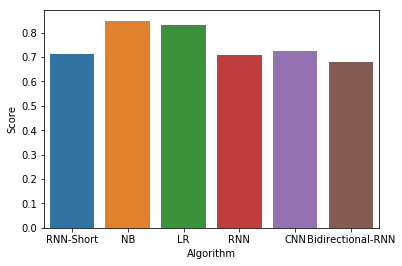

In [38]:
df = show_bar(experiment_result)